In [1]:
import numpy as np
import healpy as hp
import StellarConfig as strConfig
import fitsio
import pandas as pd
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from ugali.analysis.isochrone import factory as isochrone_factory

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from astropy.modeling.functional_models import Gaussian2D
from astropy.convolution import Model2DKernel
from astropy.convolution import convolve

In [2]:
def Mrot(alpha_pole,delta_pole,phi1_0):
    '''
    Computes the rotation matrix to coordinates aligned with a pole
    where alpha_pole, delta_pole are the poles in the original coorindates
    and phi1_0 is the zero point of the azimuthal angle, phi_1, in the new coordinates
    Critical: All angles must be in degrees!
    '''

    alpha_pole *= np.pi/180.
    delta_pole = (90.-delta_pole)*np.pi/180.
    phi1_0 *= np.pi/180.

    M1 = np.array([[np.cos(alpha_pole),np.sin(alpha_pole),0.],
                   [-np.sin(alpha_pole),np.cos(alpha_pole),0.],
                   [0.,0.,1.]])

    M2 = np.array([[np.cos(delta_pole),0.,-np.sin(delta_pole)],
                   [0.,1.,0.],
                   [np.sin(delta_pole),0.,np.cos(delta_pole)]])


    M3 = np.array([[np.cos(phi1_0),np.sin(phi1_0),0.],
                   [-np.sin(phi1_0),np.cos(phi1_0),0.],
                   [0.,0.,1.]])

    return np.dot(M3,np.dot(M2,M1))


def phi12(alpha,delta,alpha_pole,delta_pole,phi1_0):
    '''
    Converts coordinates (alpha,delta) to ones aligned with the pole (alpha_pole,delta_pole,phi1_0)
    Critical: All angles must be in degrees
    '''

    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))

    R_phi12_radec = Mrot(alpha_pole,delta_pole,phi1_0)

    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))

    vec_phi12 = vec_phi12.T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]


def phi12_rotmat(alpha,delta,R_phi12_radec):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates
    Critical: All angles must be in degrees
    '''

    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))

    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))

    vec_phi12 = vec_phi12.T

    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]

In [3]:
# rotation matrix for Phoenix
R=np.array([[0.59644670, 0.27151332, -0.75533559],
 [-0.48595429, -0.62682316, -0.60904938],
 [0.63882686, -0.73032406, 0.24192354]])

In [4]:
phoData = fitsio.read(strConfig.phoenixFile)
phoRa = phoData['RA']
phoDec = phoData['DEC']
phoWeights = phoData['WEIGHT']

In [5]:
phi1, phi2 = phi12_rotmat(phoRa, phoDec, R) # rotate to 300s frame

Text(0, 0.5, '$\\phi_2$')

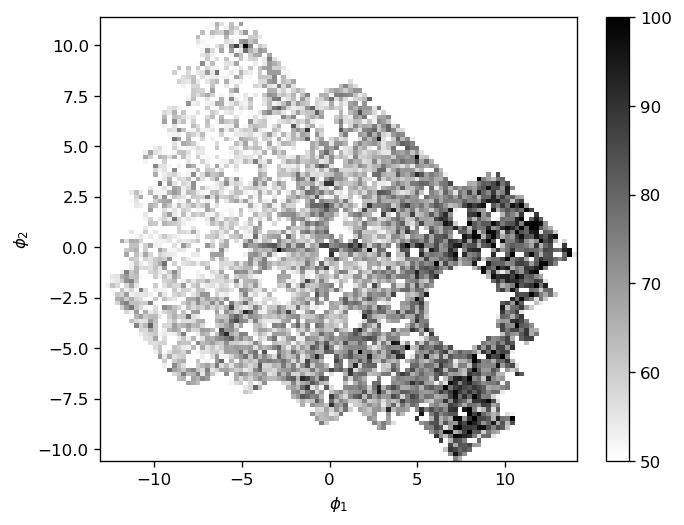

In [8]:
plt.figure(dpi=120)
plt.hist2d(phi1, phi2, bins=100, cmap="gray_r", vmax=100, vmin=50, weights = phoWeights)#, range=[[-15,15],[-5,5]], vmax=25, cmap="gray_r")
plt.colorbar()
plt.xlabel("$\phi_1$")
plt.ylabel("$\phi_2$")